# Knowledge Graph using Text Data

Graphical Representation of Knowledge with contextual information. Entities are nodes and relationships are edges.

## Steps in the process of Building a Knowledge Graph

### 1. Sentence Segmentation
The first step in building a knowledge graph is to split the text document or article into sentences.
### 2. Entity Extraction
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence. You can read more about dependency parsing in the following article.
### 3. Relation Extraction
To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.
### 4. Building the Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [1]:
import spacy
import re
import pandas as pd
import bs4

In [2]:
import requests
from spacy import displacy

In [3]:
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


nlp=spacy.load("en_core_web_sm")


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

We will build a knowledge graph from scratch by using the text from a set of movies and films related to Wikipedia articles. I have already extracted around 4,300 sentences from over 500 Wikipedia articles. Each of these sentences contains exactly two entities – one subject and one object. You can download these sentences from <a href="https://drive.google.com/file/d/1yuEUhkVFIYfMVfpA_crFGfSeJLgbPUxu/view">here.</a> 

In [4]:
df=pd.read_csv('wiki_sentences_v2.csv')
df

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [5]:
df.sample(5)

,sentence
4197,the cameras were frequently motion controlled using computers.
1503,30 to 40 films are made annually in tulu.
3775,wide screen formats were first experimented with in the 1950s.
3208,nm thin gold leafs that were already used in ancient india more than 5000 years ago.
837,afi is supported by private funding and public membership fees.


In [6]:
x=df.iloc[70]['sentence']
x

'some film schools are equipped with sound stages and post-production facilities.'

In [7]:
doc=nlp(x)
print("Token Text - Token Dependency")
for token in doc:
    print(token.text," - ", token.dep_)

Token Text - Token Dependency
some  -  det
film  -  compound
schools  -  nsubjpass
are  -  auxpass
equipped  -  ROOT
with  -  prep
sound  -  amod
stages  -  pobj
and  -  cc
post  -  amod
-  -  amod
production  -  amod
facilities  -  conj
.  -  punct


This part is known as POS(Part of Speech) Tagging. We mape out each word as a part of speech(subject, root, punctuation etc). doc=nlp(x) tokenizes x and stores it in doc. These tokens are being printed out iteratively in the form mentioned above. From here, we see we have only one subject(schools) and one object(stages).

## Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

In [8]:
def get_entities(sentence):
    #The entities
    entity1=""
    entity2=""
    
    prevTokenDep_="" # Dependency tag of previous token
    prevTokenText="" # Previous token
    
    prefix=""
    modifier=""
    
    for token in nlp(sentence):
        if token.dep_ !="punct":   
            
            #Check: Is the token a compound?
            if token.dep_ =="compound":
                prefix=token.text
                # Check: Was the previous token also a compound?
                # Then: Add current word to previous word
                if prevTokenDep_=="compound":
                    prefix=prevTokenText+" "+token.text
                    
                
            # Check: Is the token a modifier?    
            if token.dep_.endswith("mod")==True:
                modifier=token.text
                
                # Check: Was the previous word a compound?
                # Then: Add current word to previous word
                if prevTokenDep_=="compound":
                    modifier=prevTokenText+" "+token.text
                    
            # Check: Is the token the subject?    
            if token.dep_.find("subj")==True:
                entity1=modifier+" "+prefix+" "+token.text
                prefix=""
                modifier=""
                prevTokenDep_=""
                prevTokenText=""
            
            # Check: Is the token the object?
            if token.dep_.find("obj")==True:
                entity2 = modifier +" "+ prefix +" "+ token.text
                
            
            # Update the variables
            prevTokenDep_=token.dep_
            prevTokenText=token.text
        
    return [entity1.strip(),entity2.strip()]
                
                
    
    

In [9]:
x=df.sample(1)
x=x["sentence"].iloc[0]
x

'movies would become the most popular visual art form of the late victorian age.'

In [10]:
l=get_entities("the film had 200 patents")
l

['film', '200  patents']

In [11]:
entity_pairs=[]
#tqdm shows the progress bar
for i in tqdm(df["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:19<00:00, 216.27it/s]


In [12]:
#Thus we have extracted our entity pairs from the dataset. 
entity_pairs[5:10]

[['it', 'religious  awakening'],
 ['c. mackenzie', 'craig  cast'],
 ['di  francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film']]

## Relation / Predicate Extraction
Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:


In [13]:
def get_relation(sentence):
    
    doc=nlp(sentence)
    matcher=Matcher(nlp.vocab) #Matcher class object
    
    pattern = [
        {'DEP':'ROOT'},
        {'DEP':'prep','OP':'?'},
        {'DEP':'agent','OP':'?'},
        {'POS':'ADJ','OP':'?'}
    ]
    
    matcher.add("matching_1",[pattern])
    
    matches=matcher(doc)
    k=len(matches)-1
    
    span=doc[matches[k][1]:matches[k][2]]
    
    return(span.text)
    

In [14]:
get_relation("John completed the task")

'completed'

In [15]:
relations=[get_relation(i) for i in tqdm(df["sentence"])]

100%|██████████| 4318/4318 [00:19<00:00, 220.47it/s]


In [16]:
pd.Series(relations).value_counts()[:10]

is             348
was            283
released on     82
are             73
were            67
include         61
                50
's              41
released        39
have            31
dtype: int64

## Build a Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:


In [17]:
#Extract subjects
source=[i[0] for i in entity_pairs]

#Extract objects
target=[i[1] for i in entity_pairs]

kg_df=pd.DataFrame({'source':source,'target':target,'edge':relations})

In [18]:
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [19]:
G=nx.from_pandas_edgelist(kg_df,"source","target",edge_attr=True,create_using=nx.MultiDiGraph())

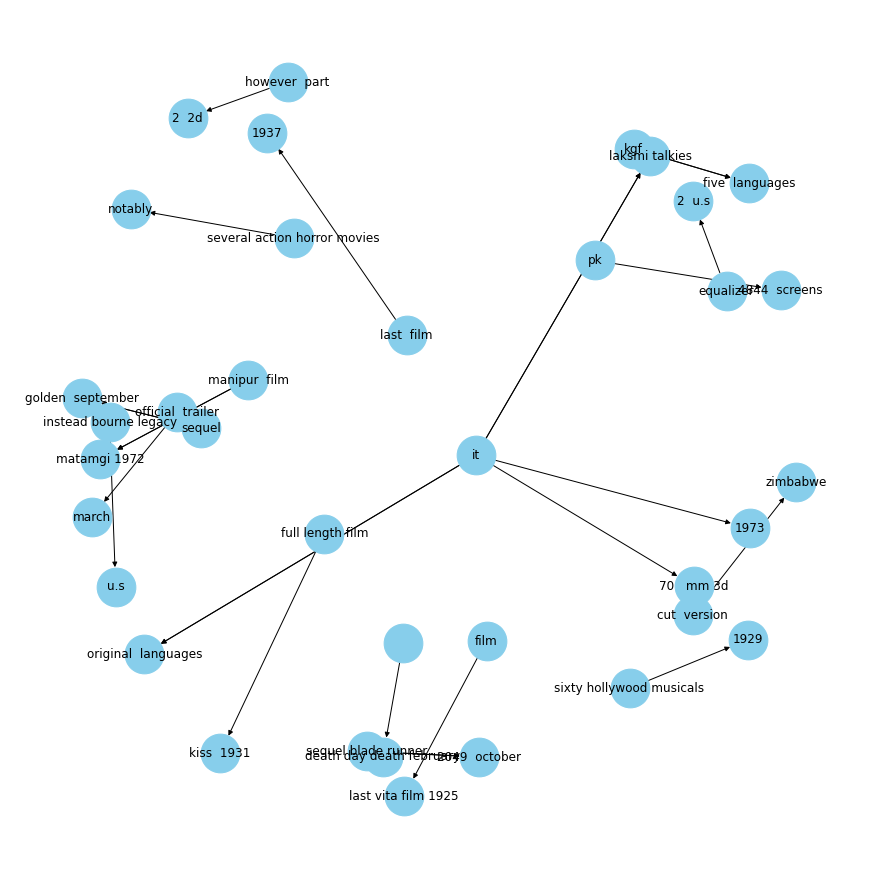

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

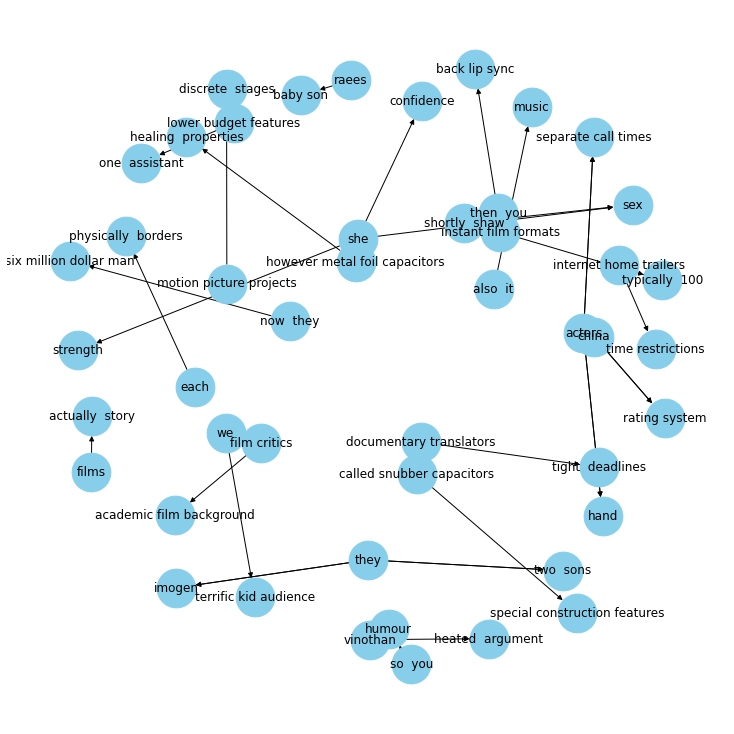

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="have"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()